In [32]:
# %%
import ot
import numpy as np
import otmol as otm
import pandas as pd
from openbabel import pybel, openbabel
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
import os
# %matplotlib widget

In [29]:
def RMSD(V, W):
    """ 
    Calculate Root-mean-square deviation from two sets of vectors V and W.
    """
    N = V.shape[0]
    return np.sqrt(np.sum((V-W)**2)/N)

def compare_lists(list1, list2):
    """
    Compare two lists and return the indices and elements where they differ.

    Args:
        list1 (list): The first list to compare.
        list2 (list): The second list to compare.

    Returns:
        list: A list of tuples, where each tuple contains the index and the differing elements
              in the format (index, element_from_list1, element_from_list2).
    """
    differences = []
    # Compare elements up to the length of the shorter list
    for i in range(len(list1)):
        if list1[i] != list2[i]:
            differences.append((i, list1[i], list2[i]))

    return differences

def parse_molecule_pairs(file_path, mol_type: str = 'water cluster'):
    """
    Parses a file containing molecule pairs separated by an underscore ('_').

    Parameters:
    ----------
    file_path : str
        Path to the file containing molecule pairs.

    Returns:
    -------
    list of lists
        A list where each element is a pair [molA, molB].
    """
    molecule_pairs = []
    with open(file_path, 'r') as file:
        if mol_type == 'water cluster' or mol_type == 'S1':
            for line in file:
                line = line.strip()  # Remove any leading/trailing whitespace
                if line:  # Skip empty lines
                    # Some lines are like "molA_molB_2", and some are like "molA_molB"
                    molecule_pairs.append([line.split('_')[0], line.split('_')[1]])
        if mol_type == 'FGG':
            next(file)  # Skip the first line
            for line in file:
                line = line.strip()
                if line:
                    molA, molB = line.split('-')
                    molecule_pairs.append([molA, molB])
    return molecule_pairs

def cost_matrix(T_A: list = None, T_B: list = None, k = 1e11):
    n = len(T_A)
    m = len(T_B)
    C = np.zeros((n, m), dtype=float)
    for i in range(n):
        for j in range(m):
            if  T_A[i] == T_B[j]:
                C[i, j] = 0
            else:
                C[i, j] = k
    return C

def permutation_to_matrix(permutation):
    """
    Converts a permutation list to a permutation matrix.
    
    Args:
        permutation (list or array): A list or array representing the permutation.
                                     For example, [2, 0, 1] means index 0 maps to 2, index 1 maps to 0, etc.
    
    Returns:
        numpy.ndarray: A permutation matrix.
    """
    n = len(permutation)
    matrix = np.zeros((n, n), dtype=int)
    for i, j in enumerate(permutation):
        matrix[i, j] = 1
    return matrix

def parse_xyz(file_path):
    """
    Parse an XYZ file to extract atom name, SYBYL atom type, or atom connectivity and coordinates.

    Args:
        file_path (str): Path to the XYZ file.

    Returns:
        tuple: Two lists - one with desired atom category and another with coordinates.
    """
    atom_types = []
    coordinates = []

    with open(file_path, 'r') as file:
        lines = file.readlines()

        # Skip the first two lines (number of atoms and comment line)
        for line in lines[2:]:
            parts = line.strip().split()
            if len(parts) >= 4:
                atom_types.append(parts[0])  # First column is the SYBYL atom type
                coordinates.append([float(parts[1]), float(parts[2]), float(parts[3])])  # Next three columns are coordinates

    return np.array(coordinates, dtype=float), np.array(atom_types, dtype=str) 

def check_bonds(B):
    """
    B is a 17 x 17 symmetric matrix. 
    Check if B[:6, 6:] and B[:14, 14:] are zero matrices.
    """
    if np.sum(B[:6, 6:]) == 0. and np.sum(B[:14, 14:]) == 0.:
        return True
    else:
        return False

def process_sy2_molecule(
    mol
):
    """
    Takes a openbabel molecule object read from an xyz file.
    Output (1) spatial coordinates, (2) atom types, and (3) bonds as numpy arrays.
    """

    n = len(mol.atoms)
    X = np.empty([n,3], dtype = float)
    T = np.empty([n], dtype = object)
    B = np.zeros([n,n], dtype = float)
    for i in range(n):
        X[i,:] = mol.atoms[i].coords
        T[i] = mol.atoms[i].type
    
    obmol = mol.OBMol
    for bond in openbabel.OBMolBondIter(obmol):
        atom1 = bond.GetBeginAtom()
        atom2 = bond.GetEndAtom()
        order = bond.GetBondOrder()
        B[atom1.GetIdx()-1, atom2.GetIdx()-1] = 1
        B[atom2.GetIdx()-1, atom1.GetIdx()-1] = 1
    return X, T, B
    
def is_S1MAW1_permutation(assignment):
    """
    Check if the assignment is a valid S1MAW1 permutation.
    
    Args:
        assignment (list): A list of integers representing the assignment.
    
    Returns:
        bool: True if the assignment is a valid S1MAW1 permutation, False otherwise.
    """
    # Check if it is an assignment
    if len(np.unique(assignment)) != 17:
        return False
    # Check if the first 6 elements are in the range 0-5
    if not all(0 <= x < 6 for x in assignment[:6]):
        return False
    # Check if the last 11 elements are in the range 6-14
    if not all(6 <= x < 14 for x in assignment[6:14]):
        return False
    # Check if the last 3 elements are in the range 14-17
    if not all(14 <= x < 17 for x in assignment[14:]):
        return False
    return True

In [21]:
def Experiment(data_path: str = None,mol_pair: list = None, method: str = 'fgw', 
               alpha_list: list = None, D_matrix: str = 'geodesic', p_list: list = None,
               setup: str = 'atom name'
               ):
    """
    Experiment with ArbAlign data.
    """
    results = []
    # Load the molecule pairs from the specified file
    for nameA, nameB in mol_pair:
        if setup == 'atom name':
            molA = next(pybel.readfile('xyz', os.path.join(data_path, nameA + '.xyz')))
            molB = next(pybel.readfile('xyz', os.path.join(data_path, nameB + '.xyz')))
            # Basic processing of the molecules
            X_A, T_A, B_A = otm.tl.process_molecule(molA) # Output (1) spatial coordinates, (2) atom types, and (3) bonds as numpy arrays.
            X_B, T_B, B_B = otm.tl.process_molecule(molB)
            if (not check_bonds(B_A)) or (not check_bonds(B_B)):
                print('Warning: the bond matrix is not correct')
            #D_A = otm.tl.geodesic_distance(X_A, B_A)
            #D_B = otm.tl.geodesic_distance(X_B, B_B)
        if setup == 'atom type':
            X_A, T_A = parse_xyz(os.path.join(data_path, 't-'+ nameA + '.xyz'))
            X_B, T_B = parse_xyz(os.path.join(data_path, 't-'+ nameB + '.xyz'))
            
        if setup == 'atom connectivity':
            X_A, T_A = parse_xyz(os.path.join(data_path, 'c-'+ nameA + '.xyz'))
            X_B, T_B = parse_xyz(os.path.join(data_path, 'c-'+ nameB + '.xyz'))
        C = cost_matrix(T_A, T_B, 1e12)
        D_A = distance_matrix(X_A, X_A)
        D_B = distance_matrix(X_B, X_B)
        rmsd_best = 1e10
        p_best = None
        P_best = None
        alpha_best = None
        if method == 'fgw':
        # Fused Gromov-Wasserstein
            for alpha in alpha_list:
                for p in p_list:
                    #if D_matrix == 'geodesic':
                    #    P = otm.tl.molecule_optimal_transport(C, D_A**p, D_B**p, method=method, alpha=alpha)
                    if D_matrix == 'euclidean':
                        P = otm.tl.molecule_optimal_transport(C, D_A**p, D_B**p, method=method, alpha=alpha)
                    assignment = np.argmax(P, axis=1)
                    if is_S1MAW1_permutation(assignment):
                        X_B_aligned = otm.tl.molecule_alignment_allow_reflection(X_A, X_B, permutation_to_matrix(assignment))
                        rmsd = RMSD(X_A, X_B_aligned[assignment])
                        if rmsd < rmsd_best:
                            rmsd_best = rmsd
                            p_best = p
                            P_best = P
                            alpha_best = alpha
            optimal_assignment = np.argmax(P_best, axis=1)
            
        if len(np.unique(optimal_assignment)) != X_A.shape[0]: # check if the assignment is 1 to 1
            print(nameA, nameB, 'Warning: the assignment is not 1 to 1')
        if compare_lists(T_A, T_B[optimal_assignment]): # check if atom names are matched
            print(nameA, nameB, 'Warning: unmatched {} exists'.format(setup))
        results.append({
            'nameA': nameA,
            'nameB': nameB,
            'RMSD(otmol+{})'.format(setup): rmsd_best,
            '# atoms': X_A.shape[0],
            'alpha': alpha_best,
            'p': p_best,
            'assignment': optimal_assignment,
            #'atomname_diff': compare_lists(T_A, T_B[optimal_assignment])
        }) 
        print(nameA, nameB, rmsd_best)

    return pd.DataFrame(results)

In [ ]:
import subprocess
data_path = "./DataArbAlign/S1-MA-W1/"
mol_pair_list_path = os.path.join(data_path, 'list')
molecule_pairs = parse_molecule_pairs(mol_pair_list_path, mol_type='water cluster')

In [ ]:
for nameA, nameB in molecule_pairs:
    subprocess.run(['zsh', 'AtomTypes.zsh', nameA + '.xyz', data_path])
    subprocess.run(['zsh', 'AtomTypes.zsh', nameB + '.xyz', data_path])
    subprocess.run(['zsh', 'AtomConn.zsh', nameA + '.xyz', data_path])
    subprocess.run(['zsh', 'AtomConn.zsh', nameB + '.xyz', data_path])

In [22]:
otmol_name_res = Experiment(data_path, molecule_pairs, setup='atom name', method='fgw', D_matrix='euclidean', alpha_list=np.linspace(0,0.1,500), p_list=[0.5,1,2,3])
#otmol_type_res = Experiment(data_path, molecule_pairs, setup='atom type', method='fgw', D_matrix='euclidean', alpha_list=np.linspace(0,0.1,500), p_list=[0.5,1,2,3])
#otmol_conn_res = Experiment(data_path, molecule_pairs, setup='atom connectivity', method='fgw', D_matrix='euclidean', alpha_list=np.linspace(0,0.1,500), p_list=[0.5,1,2,3])

s1maw1-1 s1maw1-2 0.6735284583309241
s1maw1-1 s1maw1-3 0.5839615633828438
s1maw1-1 s1maw1-4 0.11538510897871562
s1maw1-1 s1maw1-5 0.54711656292459
s1maw1-1 s1maw1-6 0.7883345576732508
s1maw1-1 s1maw1-7 0.5572347614668849
s1maw1-1 s1maw1-8 0.7214752136585885
s1maw1-1 s1maw1-9 0.8038640211937703
s1maw1-1 s1maw1-10 0.4183596086639191
s1maw1-1 s1maw1-11 0.5628080351186672
s1maw1-1 s1maw1-12 0.5535052284774181
s1maw1-1 s1maw1-13 0.7559304270901099
s1maw1-1 s1maw1-14 0.550090181098479
s1maw1-1 s1maw1-15 0.4902559432093143
s1maw1-1 s1maw1-16 0.4113452503916782
s1maw1-1 s1maw1-17 0.9658364403955562
s1maw1-1 s1maw1-18 0.923923312864299
s1maw1-1 s1maw1-19 0.9762692668033504
s1maw1-1 s1maw1-20 0.7673452735285906


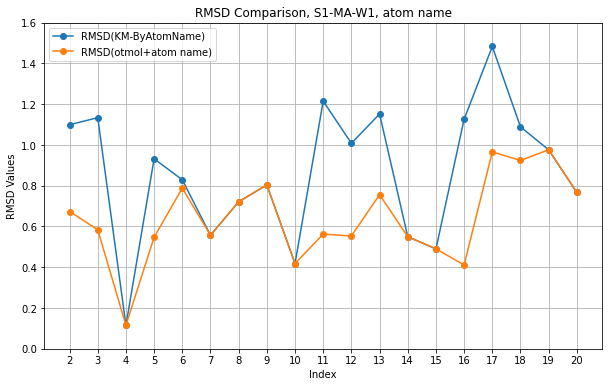

In [23]:
# Concatenate otmol_res and df along the columns
arbalign_res = pd.read_csv(os.path.join(data_path, 'rmsd-2017.dat'), sep='\s+')
combined_df = pd.concat([arbalign_res, otmol_name_res], axis=1)
# Plot the specified columns against the Index column
columns_to_plot = ["RMSD(KM-ByAtomName)", "RMSD(otmol+atom name)"]
#"RMSD(KM-ByAtomType)", "RMSD(KM-byAtomConn)", 
plt.figure(figsize=(10,6))
# Plot each column against the Index column
for column in columns_to_plot:
    plt.plot(range(2,21), combined_df[column], marker='o', label=column)
plt.title("RMSD Comparison, S1-MA-W1, atom name")
plt.xlabel("Index")
plt.ylabel("RMSD Values")
plt.ylim(0, 1.6)
plt.xticks(range(2,21))
plt.legend()
plt.grid(True)

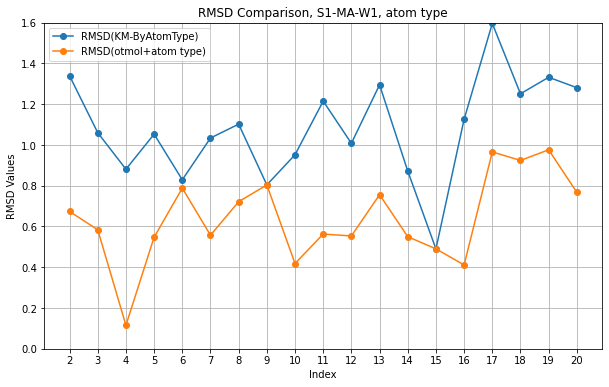

In [ ]:
arbalign_res = pd.read_csv(os.path.join(data_path, 'rmsd-2017.dat'), sep='\s+')
combined_df = pd.concat([arbalign_res, otmol_type_res], axis=1)
columns_to_plot = ["RMSD(KM-ByAtomType)", "RMSD(otmol+atom type)"]
#"RMSD(KM-ByAtomType)", "RMSD(KM-byAtomConn)", 
plt.figure(figsize=(10,6))
# Plot each column against the Index column
for column in columns_to_plot:
    plt.plot(range(2,21), combined_df[column], marker='o', label=column)
plt.title("RMSD Comparison, S1-MA-W1, atom type")
plt.xlabel("Index")
plt.ylabel("RMSD Values")
plt.ylim(0, 1.6)
plt.xticks(range(2,21))
plt.legend()
plt.grid(True)

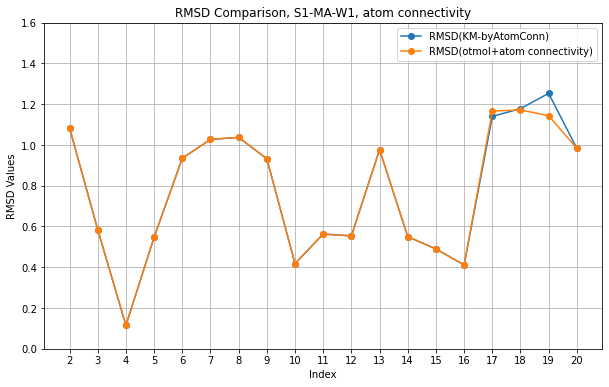

In [ ]:
arbalign_res = pd.read_csv(os.path.join(data_path, 'rmsd-2017.dat'), sep='\s+')
combined_df = pd.concat([arbalign_res, otmol_conn_res], axis=1)
columns_to_plot = ["RMSD(KM-byAtomConn)", "RMSD(otmol+atom connectivity)"]
#"RMSD(KM-ByAtomType)", "RMSD(KM-byAtomConn)", 
plt.figure(figsize=(10,6))
# Plot each column against the Index column
for column in columns_to_plot:
    plt.plot(range(2,21), combined_df[column], marker='o', label=column)
plt.title("RMSD Comparison, S1-MA-W1, atom connectivity")
plt.xlabel("Index")
plt.ylabel("RMSD Values")
plt.ylim(0, 1.6)
plt.xticks(range(2,21))
plt.legend()
plt.grid(True)

In [40]:
otmol_name_res

,nameA,nameB,RMSD(otmol+atom name),# atoms,alpha,p,assignment
0,s1maw1-1,s1maw1-2,0.673528,17,0.000200,2,"[0, 3, 4, 2, 1, 5, 6, 7, 9, 8, 10, 13, 12, 11,..."
1,s1maw1-1,s1maw1-3,0.583962,17,0.000200,2,"[0, 2, 4, 3, 1, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,s1maw1-1,s1maw1-4,0.115385,17,0.000200,1,"[0, 2, 4, 3, 1, 5, 9, 7, 6, 8, 10, 13, 11, 12,..."
3,s1maw1-1,s1maw1-5,0.547117,17,0.000200,1,"[0, 2, 4, 3, 1, 5, 9, 7, 6, 8, 10, 13, 11, 12,..."
4,s1maw1-1,s1maw1-6,0.788335,17,0.000200,2,"[0, 2, 4, 3, 1, 5, 9, 7, 12, 6, 10, 13, 8, 11,..."
5,s1maw1-1,s1maw1-7,0.557235,17,0.000200,2,"[0, 3, 1, 4, 2, 5, 6, 7, 9, 8, 10, 11, 13, 12,..."
6,s1maw1-1,s1maw1-8,0.721475,17,0.000200,2,"[0, 2, 4, 3, 1, 5, 6, 7, 13, 8, 10, 11, 9, 12,..."
7,s1maw1-1,s1maw1-9,0.803864,17,0.000200,2,"[0, 1, 2, 3, 4, 5, 6, 7, 12, 8, 10, 13, 9, 11,..."
8,s1maw1-1,s1maw1-10,0.418360,17,0.000200,2,"[0, 4, 1, 3, 2, 5, 8, 7, 9, 6, 10, 12, 13, 11,..."
9,s1maw1-1,s1maw1-11,0.562808,17,0.000200,2,"[0, 4, 1, 3, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


In [41]:
otmol_type_res

,nameA,nameB,RMSD(otmol+atom type),# atoms,alpha,p,assignment
0,s1maw1-1,s1maw1-2,0.673535,17,0.000200,2,"[0, 3, 4, 2, 1, 5, 6, 7, 9, 8, 10, 13, 12, 11,..."
1,s1maw1-1,s1maw1-3,0.583974,17,0.000200,2,"[0, 2, 4, 3, 1, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,s1maw1-1,s1maw1-4,0.115371,17,0.000200,1,"[0, 2, 4, 3, 1, 5, 9, 7, 6, 8, 10, 13, 11, 12,..."
3,s1maw1-1,s1maw1-5,0.547123,17,0.000200,1,"[0, 2, 4, 3, 1, 5, 9, 7, 6, 8, 10, 13, 11, 12,..."
4,s1maw1-1,s1maw1-6,0.788341,17,0.000200,2,"[0, 2, 4, 3, 1, 5, 9, 7, 12, 6, 10, 13, 8, 11,..."
5,s1maw1-1,s1maw1-7,0.557225,17,0.000200,2,"[0, 3, 1, 4, 2, 5, 6, 7, 9, 8, 10, 11, 13, 12,..."
6,s1maw1-1,s1maw1-8,0.721473,17,0.000200,2,"[0, 2, 4, 3, 1, 5, 6, 7, 13, 8, 10, 11, 9, 12,..."
7,s1maw1-1,s1maw1-9,0.803878,17,0.000200,2,"[0, 1, 2, 3, 4, 5, 6, 7, 12, 8, 10, 13, 9, 11,..."
8,s1maw1-1,s1maw1-10,0.418361,17,0.000200,2,"[0, 4, 1, 3, 2, 5, 8, 7, 9, 6, 10, 12, 13, 11,..."
9,s1maw1-1,s1maw1-11,0.562818,17,0.000200,2,"[0, 4, 1, 3, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


In [33]:
# %%
# Read the molecules
molA = next(pybel.readfile("sy2", "./DataArbAlign/S1-MA-W1_xuhang/s1maw1-1_chimera.sy2"))
#molB = next(pybel.readfile("xyz", "./DataArbAlign/S1-MA-W1/s1maw1-20.xyz"))
#molA = next(pybel.readfile("xyz", "./DataArbAlign/S1-MA-W1/s1maw1-1.xyz"))

In [35]:
X_A, T_A, B_A = process_sy2_molecule(molA) # Output (1) spatial coordinates, (2) atom types, and (3) bonds as numpy arrays.
#X_B, T_B, B_B = otm.tl.process_molecule(molB)
T_A
#otm.pl.plot_molecule(X_A, T_A, B_A, coloring = 'type', sizing = 'type')
#otm.pl.plot_molecule(X_B, T_B, B_B, coloring = 'type', sizing = 'type')

array(['Sac', 'O3', 'O3', 'O3', 'O2', 'HO', 'H', 'N3+', 'H', 'H', 'C3',
       'H', 'H', 'H', 'O3', 'HO', 'HO'], dtype=object)

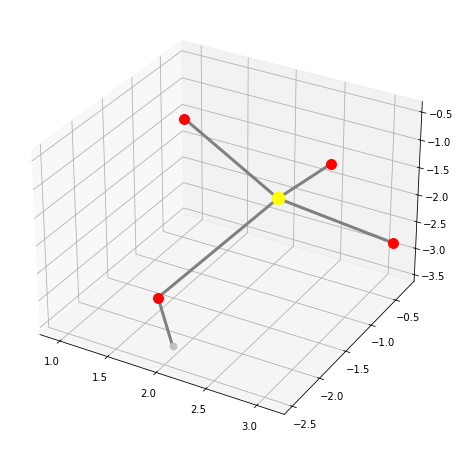

In [9]:
otm.pl.plot_molecule(X_A[:6], T_A[:6], B_A[:6,:6], coloring = 'type', sizing = 'type')

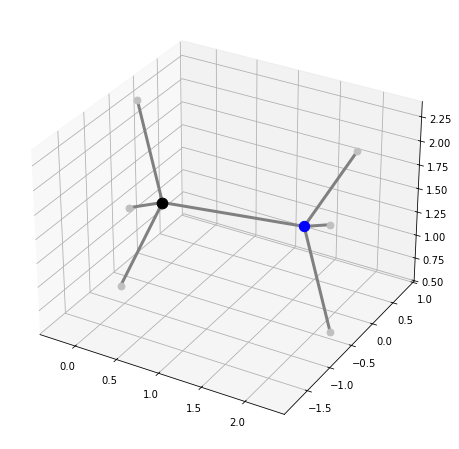

In [10]:
otm.pl.plot_molecule(X_A[6:14], T_A[6:14], B_A[6:14,6:14], coloring = 'type', sizing = 'type')

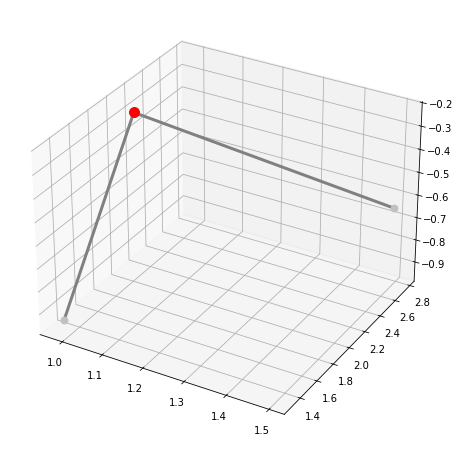

In [11]:
otm.pl.plot_molecule(X_A[14:], T_A[14:], B_A[14:,14:], coloring = 'type', sizing = 'type')

NameError: name 'otmol_res' is not defined

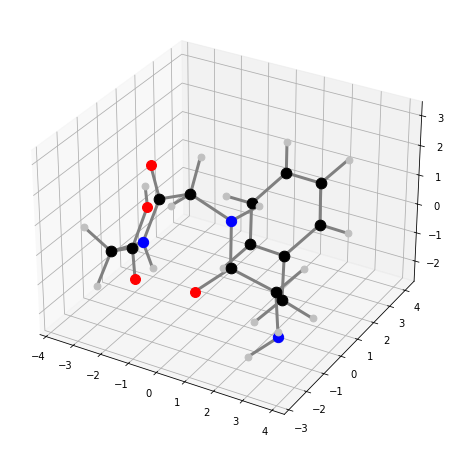

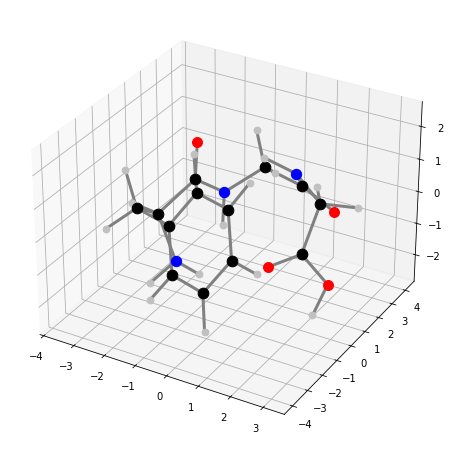

In [29]:
# %%
def permutation_to_matrix(permutation):
    """
    Converts a permutation list to a permutation matrix.
    
    Args:
        permutation (list or array): A list or array representing the permutation.
                                     For example, [2, 0, 1] means index 0 maps to 2, index 1 maps to 0, etc.
    
    Returns:
        numpy.ndarray: A permutation matrix.
    """
    n = len(permutation)
    matrix = np.zeros((n, n), dtype=int)
    for i, j in enumerate(permutation):
        matrix[i, j] = 1
    return matrix
# Basic processing of the molecules
X_A, T_A, B_A = otm.tl.process_molecule(molA) # Output (1) spatial coordinates, (2) atom types, and (3) bonds as numpy arrays.
X_B, T_B, B_B = otm.tl.process_molecule(molB)
otm.pl.plot_molecule(X_A, T_A, B_A, coloring = 'type', sizing = 'type')
otm.pl.plot_molecule(X_B, T_B, B_B, coloring = 'type', sizing = 'type')
P = permutation_to_matrix(otmol_res['assignment'][0])
X_B_aligned = otm.tl.molecule_alignment_allow_reflection(X_A, X_B, P) 
print(RMSD(X_A, X_B_aligned[np.argmax(P, axis=1)]))
print(T_A)
print(T_B[np.argmax(P, axis=1)])
print(compare_lists(T_A, T_B[np.argmax(P, axis=1)]))
otm.pl.plot_alignment(X_A, X_B_aligned, B_A, B_B, P, weight_cutoff=0.01)
plt.show()


In [ ]:
# %%
C = otm.tl.molecule_physchem_distance(T_A, T_B)
D_A = otm.tl.geodesic_distance(X_A, B_A)
D_B = otm.tl.geodesic_distance(X_B, B_B)

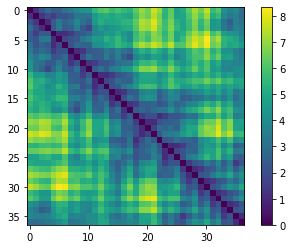

In [ ]:
# %%
# Fused Gromov-Wasserstein
DD_A = distance_matrix(X_A, X_A)
DD_B = distance_matrix(X_B, X_B)
P = otm.tl.molecule_optimal_transport(C, D_A+17*DD_A, D_B+17*DD_B, method='fgw', alpha=0.1)
plt.show()
plt.imshow(DD_A)
plt.colorbar()

2.4043992558309104
[(0, 'O', 'H'), (5, 'H', 'O'), (8, 'H', 'C'), (9, 'C', 'H'), (14, 'N', 'C'), (17, 'O', 'N'), (18, 'C', 'H'), (19, 'N', 'C'), (23, 'C', 'N'), (25, 'H', 'O')]


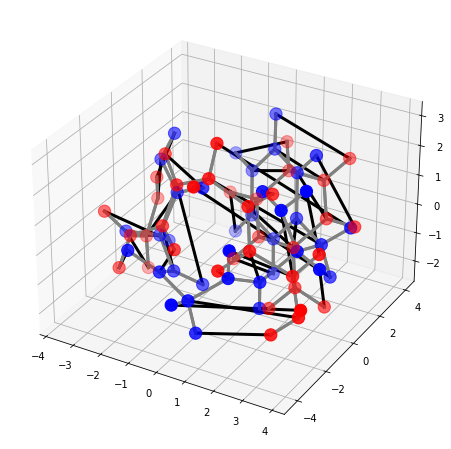

In [ ]:
X_B_aligned = otm.tl.molecule_alignment_allow_reflection(X_A, X_B, P) 
print(RMSD(X_A, X_B_aligned[np.argmax(P, axis=1)]))
print(compare_lists(T_A, T_B[np.argmax(P, axis=1)]))
otm.pl.plot_alignment(X_A, X_B_aligned, B_A, B_B, P, weight_cutoff=0.01)
plt.show()

2.237235753083236


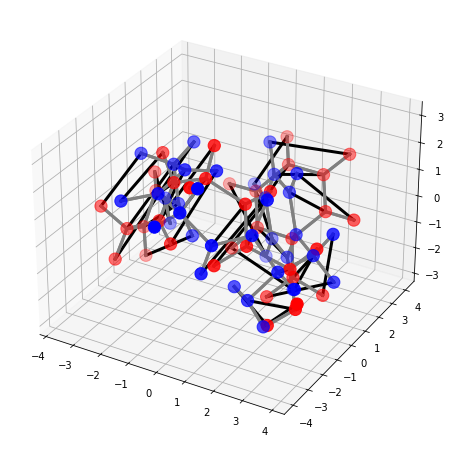

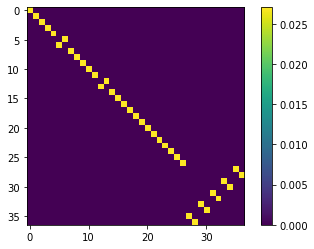

In [ ]:
# %%
# Gromov-Wasserstein
P = otm.tl.molecule_optimal_transport(C, D_A, D_B, method='gw', alpha=0.9)
X_B_aligned = otm.tl.molecule_alignment_allow_reflection(X_A, X_B, P)
otm.pl.plot_alignment(X_A, X_B_aligned, B_A, B_B, P)
print(RMSD(X_A, X_B_aligned[np.argmax(P, axis=1)]))
plt.show()
plt.imshow(P)
plt.colorbar()


No more edges in the graph.
2.1552160380660763


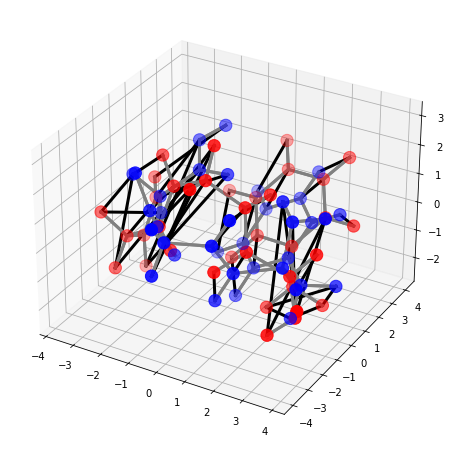

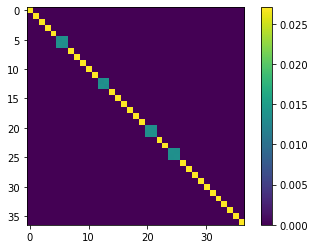

In [ ]:
# %%
# Supervised Gromov-Wasserstein
P = otm.tl.molecule_optimal_transport(C, D_A, D_B, method='sgw', sgw_cutoff=5)
X_B_aligned = otm.tl.molecule_alignment_allow_reflection(X_A, X_B, P)
otm.pl.plot_alignment(X_A, X_B_aligned, B_A, B_B, P)
print(RMSD(X_A, X_B_aligned[np.argmax(P, axis=1)]))
plt.show()
plt.imshow(P)
plt.colorbar()

# of potential non-zeros in P: 210
2.1552260859951216
[]


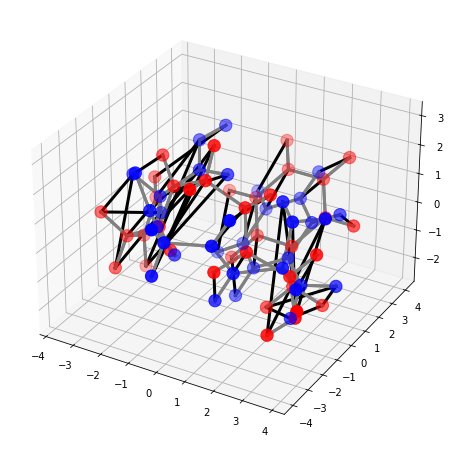

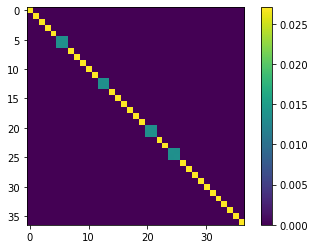

In [ ]:
# %%
# Fused supervised Gromov-Wasserstein
P = otm.tl.molecule_optimal_transport(C, D_A, D_B, method='fsgw', sgw_cutoff=5, alpha=0.5)
X_B_aligned = otm.tl.molecule_alignment_allow_reflection(X_A, X_B, P)
otm.pl.plot_alignment(X_A, X_B_aligned, B_A, B_B, P)
print(RMSD(X_A, X_B_aligned[np.argmax(P, axis=1)]))
print(compare_lists(T_A, T_B[np.argmax(P, axis=1)]))
plt.show()
plt.imshow(P)
plt.colorbar()